In [11]:
import pandas as pd
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD

from rgroupinterm.rgroupenumeration import EnumRGroups

rdBase.DisableLog('rdApp.*')

In [12]:
from collections import defaultdict

def get_source_mapping(input_mol):
    join_dict = {}
    for atom in input_mol.GetAtoms():
        map_num = atom.GetAtomMapNum()
        if map_num > 0:
            join_dict[map_num] = (atom)

    # transfer the atom maps to the neighbor atoms
    for idx, atom in join_dict.items():
        nbr_1 = [x.GetOtherAtom(atom) for x in atom.GetBonds()][0]
        nbr_1.SetAtomMapNum(idx)

    # remove the dummy atoms
    new_mol = Chem.DeleteSubstructs(input_mol, Chem.MolFromSmarts('[#0]'))

    # get the new atoms with AtomMapNum, these will be connected
    source_atom_dict = {}
    for atom in new_mol.GetAtoms():
        map_num = atom.GetAtomMapNum()
        if map_num > 0:
            if atom.HasProp("SourceAtomIdx"):
                source_atom_dict[map_num] = atom.GetIntProp("SourceAtomIdx")

    return source_atom_dict

In [13]:
smiles = [
    'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc(O)cc1)N2',
    '[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1'
]
mols = [Chem.MolFromSmiles(x) for x in smiles]

for i, mol in enumerate(mols):
    Chem.Kekulize(mol, clearAromaticFlags=True)
    for atom in mol.GetAtoms():
        atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
        atom.SetIntProp("SourceMol",i)

res = rdFMCS.FindMCS(mols,
                        matchValences=True,
                        ringMatchesRingOnly=True,
                        completeRingsOnly=True,
                        timeout=2)
core = Chem.MolFromSmarts(res.smartsString)

# create dataframe with columns Core, R1, ... Rn
res, _ = rdRGD.RGroupDecompose([core],
                                mols,
                                asSmiles=False,
                                asRows=False)
df_rgroup = pd.DataFrame(res)

stereocenters = defaultdict(dict)
# need to do twice because core only keeps atom dictionary of first input
for i, mol in enumerate(mols):
    res_core = df_rgroup['Core'][i] 
    mapping_dict = get_source_mapping(res_core)
    for key, value in mapping_dict.items():
        stereocenters[i][key] = mol.GetAtomWithIdx(value).GetChiralTag()
print(stereocenters)

defaultdict(<class 'dict'>, {0: {3: rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 2: rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 1: rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED}, 1: {2: rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW, 3: rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 1: rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED}})


In [14]:
# smiles = [
#     'CC(C)(C)c1ccc2c(c1)[C@H]1OCCC[C@H]1[C@H](c1ccc(O)cc1)N2',
#     '[NH3+]C[C@H]1CC[C@@H]2[C@H](O1)c1cc(C(F)(F)F)ccc1N[C@H]2c1ccccc1'
# ]
# mols = [Chem.MolFromSmiles(x) for x in smiles]

generator = EnumRGroups(stereocenters)

df_interm, core = generator.generate_intermediates(mols)
intermediates = df_interm['Intermediate'].tolist()

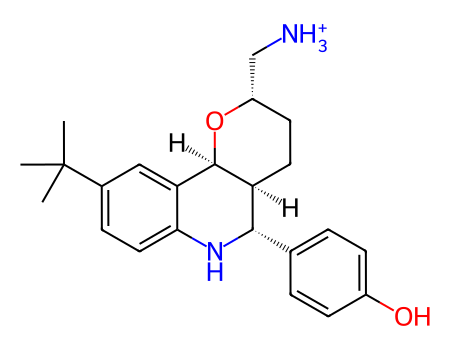

In [15]:
intermediates[2]

In [16]:
from rgroupinterm.rgroup_highlighting import plot_highlighted
image = plot_highlighted(mols[0], mols[1], intermediates[1:-1], core)
image

IndexError: list index out of range